In [91]:
import numpy as np
import matplotlib.pyplot as plt
from line_profiler import LineProfiler
import os

import gaez_data_loader
import simulation
import toolbox

# use importlib for now
import importlib
importlib.reload(simulation)
importlib.reload(toolbox)
importlib.reload(gaez_data_loader)

<module 'gaez_data_loader' from 'C:\\Users\\leoko\\PycharmProjects\\pythonProject\\gaez_data_loader.py'>

## Environments

Disjoint Environments

In Lattice.init_env_from_gaez(): Input environment contains water. Set to zero.


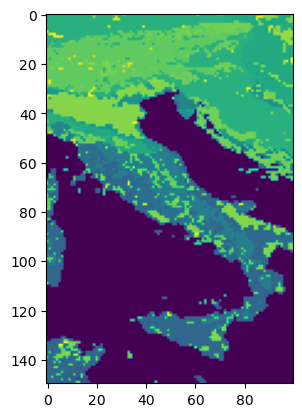

In [92]:
# get single GAEZ environment
base_dir = r"C:\Users\leoko\Documents\Vienna_CSH\gaez_v4_data"
fn = "aez_33_classes_low_res.tif"

gaez_data = gaez_data_loader.GlobalAezV4()
gaez_data.load(os.path.join(base_dir, fn), idx=0, verbose=False)
gaez_data.set_woi(r0=500, c0=2270, n_rows=150, n_cols=100) # crop europe  150 before
gaez_data.get_distance_matrix(verbose=False) # load distance matrix
env_gaez = gaez_data.get_env(water_var=0)

plt.imshow(gaez_data._array)

Non-disjoint environments

In Lattice.init_env_from_gaez(): Input environment contains water. Set to zero.
In Lattice.init_env_from_gaez(): Input environment contains water. Set to zero.
In Lattice.init_env_from_gaez(): Input environment contains water. Set to zero.


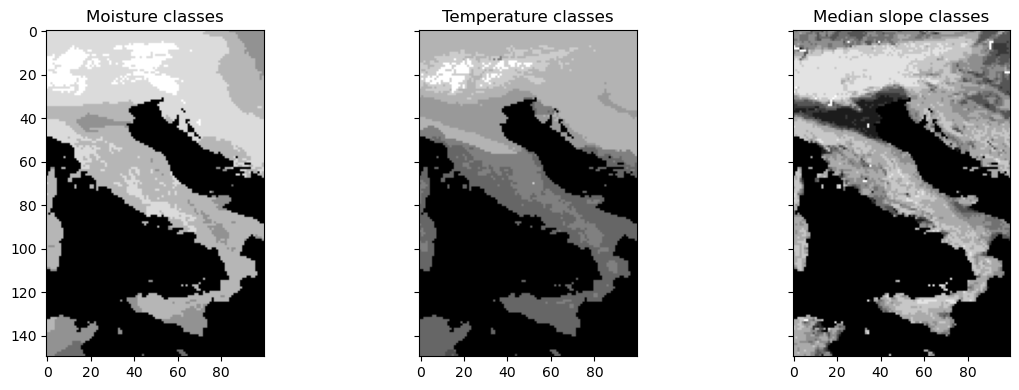

In [93]:
# load environments - here temperature, moisture, and median slope
env_list = []
base_dir = r"C:\Users\leoko\Documents\Vienna_CSH\gaez_v4_data"
fn_list = ["Gaez_Moisture_Regime_Class.tif", "Gaez_Thermal_Regime_Class.tif", "Gaez_Median_Slope_Class.tif"]

for fn in fn_list:
    gaez_data = gaez_data_loader.GlobalAezV4()
    gaez_data.load(os.path.join(base_dir, fn), idx=0, verbose=False)
    gaez_data.set_woi(r0=500, c0=2270, n_rows=150, n_cols=100) # crop europe  150 before
    gaez_data.get_distance_matrix(verbose=False) # load distance matrix
    env_gaez = gaez_data.get_env(water_var=0)
    env_list.append(env_gaez)
    env_list.append(gaez_data._array)  # for visualization

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 4), sharex=True, sharey=True)

ax1.imshow(env_list[1], cmap="gray")
ax1.set_title("Moisture classes")
ax2.imshow(env_list[3], cmap="gray")
ax2.set_title("Temperature classes")
ax3.imshow(env_list[5], cmap="gray")
ax3.set_title("Median slope classes")

fig.tight_layout()

save_path = r"C:\Users\leoko\Documents\Vienna_CSH\images_plot"
save_name = "moist_temp_slope.png"
fn = os.path.join(save_path, save_name)

# fig.savefig(fn, dpi=200)

In [94]:
# get multiple envs into one if desired
env_gaez_multiple = toolbox.get_envs_from_multiple_maps(env_list[1::2], water_var=0)

Artificial environments

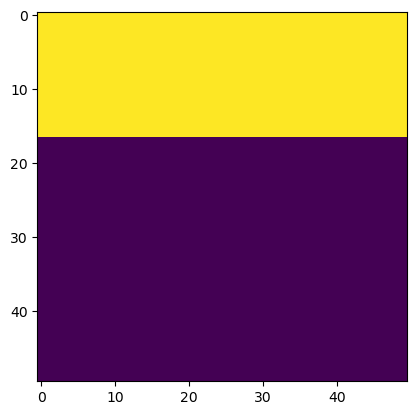

In [95]:
# engineer artificial environment
env_artificial = np.zeros([50, 50, 4])

env_artificial[:17, :, 0] = 1
env_artificial[10:25, :, 3] = 1

env_artificial[17:34, :, 1] = 1
env_artificial[34:, :, 2] = 1

plt.imshow(env_artificial[..., 0])

## Geography modulation

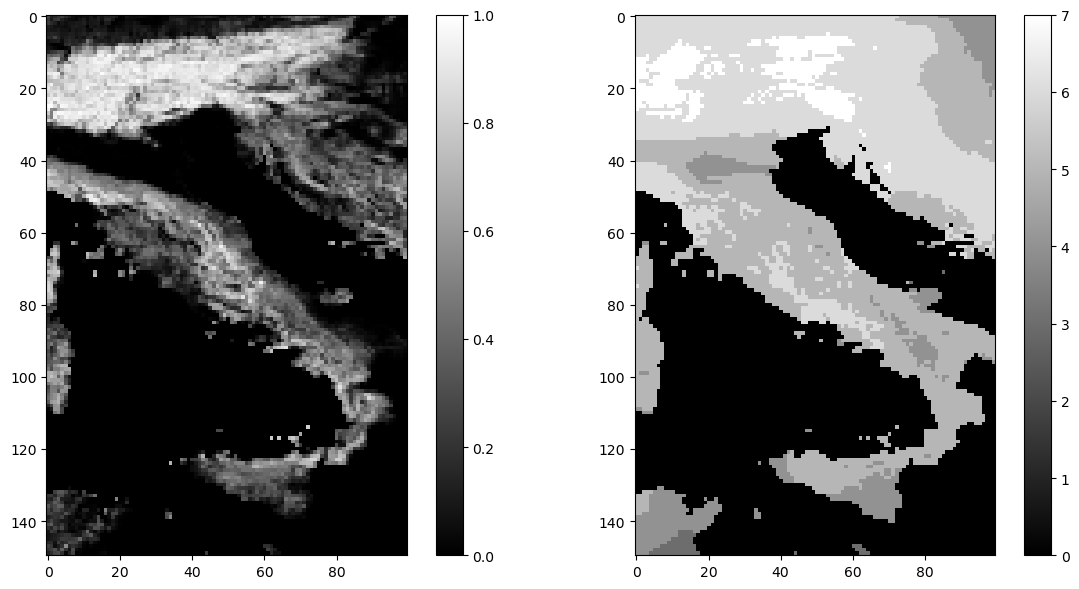

In [96]:
# Get weighted elevation average
names = ["Gaez_ShareOfClass_58_Range.tif", "Gaez_ShareOfClass_816_Range.tif", "Gaez_ShareOfClass_1630_Range.tif",
         "Gaez_ShareOfClass_3045_Range.tif", "Gaez_ShareOfClass_45More_Range.tif"]

elevations_median = [(8 + 5) / 2, (8 + 16) / 2, (16 + 30) / 2, (30 + 45) / 2, 50]  # order must match names
data_sets = []

for fn in names:
    gaez_data = gaez_data_loader.GlobalAezV4()
    gaez_data.load(os.path.join(base_dir, fn), idx=0, verbose=False)
    gaez_data.set_woi(r0=500, c0=2270, n_rows=150, n_cols=100)

    share_class_data = np.copy(gaez_data._array)

    test_mask = share_class_data < 0  # water areas
    share_class_data[test_mask] = 0

    data_sets.append(share_class_data)

weighted_elevation = np.zeros_like(data_sets[0])

for median_slope, data in zip(elevations_median, data_sets):  # weighted sum
    weighted_elevation += median_slope * data

# normalize
elevation_penalties = weighted_elevation / np.amax(weighted_elevation)

# add geographical penalty
# lattice.load_geo_constraints(elevation_penalties)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
pl1 = ax1.imshow(elevation_penalties, cmap="gray")
fig.colorbar(pl1, ax=ax1)
pl2 = ax2.imshow(env_list[1], cmap="gray")
fig.colorbar(pl2, ax=ax2)

fig.tight_layout()

# fig.savefig(os.path.join(save_dir, "penalites_and_map.png"), dpi=200)

## Create Instance

In [97]:
# load instance
params_instance = {"num_iter": 15_000, "seed": 51, "idx_start": (0, 0), "population_growth_rate": 1 / 30,
                   "max_productivity": 800, "n_rows": 150, "n_cols": 100, "starting_pop": 10}

base_abm = simulation.Lattice(**params_instance)

In meth: lattice.load_env: The environment has 24 mutually exclusive types.


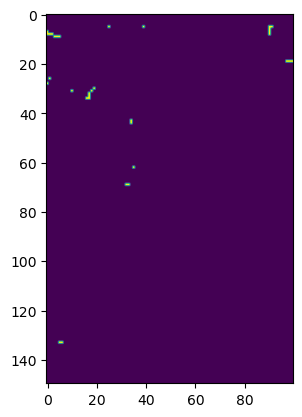

In [98]:
# load environment - here random
base_abm.load_env(env=env_gaez_multiple, kind="custom", num_env_vars=None, correlation_length=0.05, verbose=True)

# visualize
plt.imshow(base_abm.env[:, :, 23])

## Fission Rules

In [99]:
# set fission rules
fission_bounds = (params_instance["starting_pop"], 2 * np.floor(base_abm.productivity_step_size))

migration_threshold = 1 * np.floor(base_abm.productivity_step_size)  # requires at least one matching skill

params_fission = {"migration_threshold": migration_threshold, "include_diagonals": False, "search_distance_pixels": 2,
                  "search_intelligently": True, "max_distance_km": None, "dist_type": "linear",
                  "params_are_relative": False}

base_abm.set_fission_rules(fission_bounds, **params_fission)

# Check set rates in absolute numbers to validate if there are no errors
print("Maximum carrying capacity is", base_abm.max_productivity)
print("Bounds for fission probabilities (min, max) are", base_abm.pop_min, base_abm.pop_max)
print("Number of uninhabitable cells is", np.sum(base_abm.is_uninhabitable))
print("Migration threshold is", base_abm.migration_thresh)

Maximum carrying capacity is 800
Bounds for fission probabilities (min, max) are 10 66.0
Number of uninhabitable cells is 6721
Migration threshold is 33.0


## Skill mutation rules

In [100]:
# set mutation rules
n_min, n_max = params_instance["starting_pop"], 2 * np.floor(base_abm.productivity_step_size)

params_adaptive = {"p_gain_useful": 1., "p_gain_useless": 0.01, "p_lose_useful": 0, "p_lose_useless": 1.,
                   "dist_type": "linear", "n_min": n_min, "n_max": n_max, "bounds_are_relative": False}

params_mutation = {"env_mutation_rate": None, "skill_mutation_rate": 0.01, "skill_mutation_method": "adaptive",
                   "params_adaptive": params_adaptive}

base_abm.set_mutation_rules(**params_mutation)

print("Base skill mutation rate is", base_abm.skill_mutation_rate)
print("Bounds for skill mutation are (min, max):", base_abm.min_pop_mutation, base_abm.max_pop_mutation)

Base skill mutation rate is 0.01
Bounds for skill mutation are (min, max): 10 66.0


## Other parameters

In [101]:
# decide if speed-up is possible
base_abm.set_speed_params()
print("Use valid neighbor flag:", base_abm.use_valid_neighs_flag)

Use valid neighbor flag: True


In [104]:
# Set geographical penalties
base_abm.load_geo_constraints(elevation_penalties, geo_constraints_scale=0.5)

In [105]:
# add line profiler if desired
profiler_line = LineProfiler()
profiler_line.enable_by_count()
profiler_line.add_function(base_abm.migrate_to)

In [106]:
# customize initial skill vector - usually set identical to environment
print(base_abm.env[base_abm.r0, base_abm.c0])

base_abm.skills[base_abm.r0, base_abm.c0] = base_abm.env[base_abm.r0, base_abm.c0]

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## Run

In [107]:
# run
base_abm.run()

100%|██████████| 14999/14999 [19:39<00:00, 12.71it/s]


In [108]:
# line profiler output
profiler_line.print_stats()

Timer unit: 1e-07 s

Total time: 1051.39 s
File: C:\Users\leoko\PycharmProjects\pythonProject\simulation.py
Function: migrate_to at line 426

Line #      Hits         Time  Per Hit   % Time  Line Contents
   426                                               def migrate_to(self, idx_r, idx_c, search_empty_cells=True):
   427                                                   """ This is the core loop that is intended for NUMBA to vastly speed up the FOR loop.
   428                                                   Loops through occupied cells, selects a migration location for each cell based on a prob. distribution.
   429                                                   Reverse search works as follows:
   430                                                   1 - get populations from all sites a distance d away from the empty site
   431                                                   2 - calculate carrying capacity (productivity) using env from empty site and skills at occupied site

## Get statistics

In [109]:
save_dir = r"C:\Users\leoko\Documents\Vienna_CSH\images_plot"

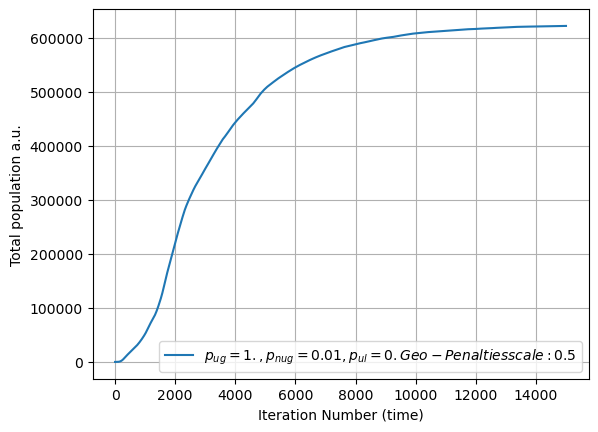

In [120]:
# get population
population = base_abm.population
# population /= base_abm.productivity_step_size

population[np.isnan(population)] = 0 # to clean for NaN values
pop_total = np.sum(population, axis=(1, 2))

fig = plt.figure()
plt.plot(pop_total, label=r"$p_{ug}=1., p_{nug}=0.01, p_{ul}=0. Geo-Penalties scale: 0.5$")
plt.ylabel("Total population a.u.")
plt.xlabel("Iteration Number (time)")
plt.grid()
plt.legend()

# fig.savefig(os.path.join(save_dir, "Italy_only.png"))

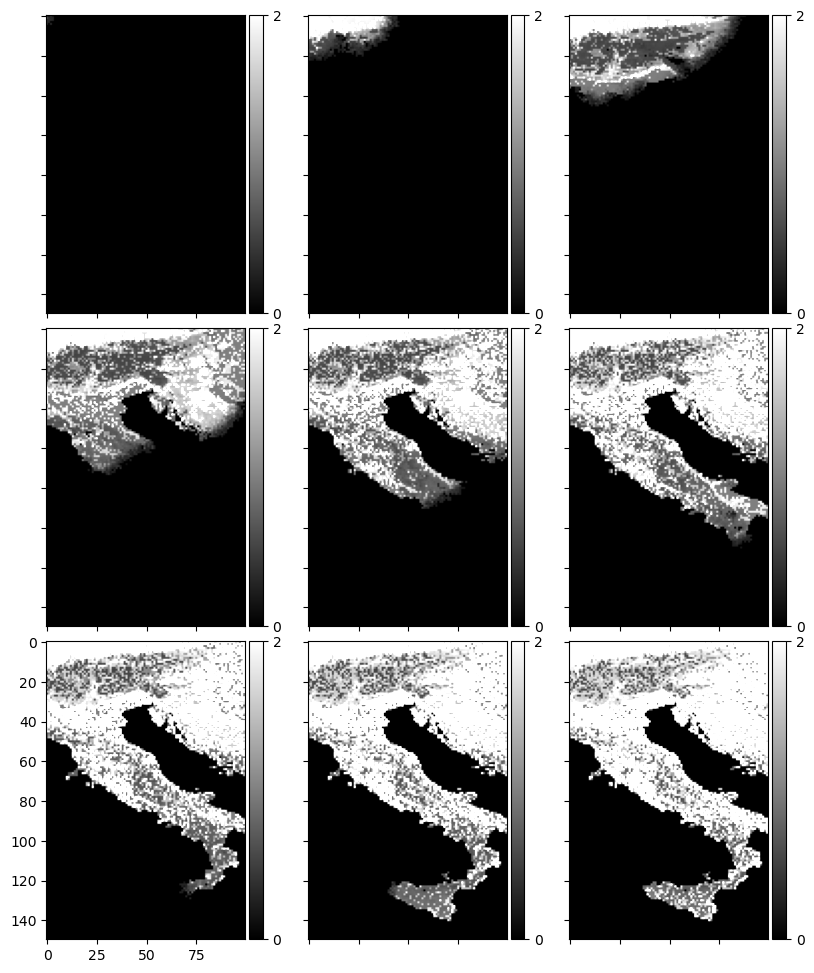

In [111]:
# Plot population at different instances of time
from mpl_toolkits.axes_grid1 import ImageGrid

_ = plt.figure(figsize=(12, 12))

# A grid of 2x2 images. Each image has its own colorbar.
grid = ImageGrid(
    fig, 111,  # similar to fig.add_subplot(144).
    nrows_ncols=(3, 3), axes_pad=(0.45, 0.15), label_mode="1", share_all=True,
    cbar_location="right", cbar_mode="each", cbar_size="7%", cbar_pad="2%")

idx = 100
vlim = (0, 2)
for ax, cax in zip(grid, grid.cbar_axes):
    im = ax.imshow(base_abm.population[idx] / base_abm.productivity_step_size, cmap="gray", vmin=vlim[0], vmax=vlim[1])
    cb = cax.colorbar(im)
    cb.set_ticks((vlim[0], vlim[1]))
    idx += 700

# fig.savefig(os.path.join(save_dir, "Italy_only_pop_instances.png"), dpi=200)